# Visualization of a Simple Stochastic Gradient Descent (TensorFlow-2.0)

Here we visualize the minimization of the loss with the SGD algorithm in its variants vanilla SGD, batch SGD and minibatch SGD. For this we consider a linear model with only two weights (the slope and the offset).

Based on [this notebook](https://github.com/tensorflow/docs/blob/master/site/en/r2/tutorials/quickstart/advanced.ipynb).

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
tf.version.VERSION

'2.0.0-beta1'

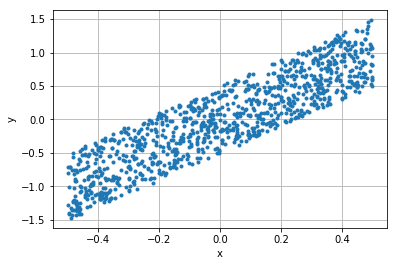

In [3]:
# Create a linear function with noise as our data
nsamples = 1000
ref_slope = 2.0
ref_offset = 0.0
noise = np.random.random((nsamples, 1)) - 0.5    # -0.5 to center the noise
x_train = np.random.random((nsamples, 1)) - 0.5  # -0.5 to center x around 0
y_train = ref_slope * x_train + ref_offset + noise

plt.plot(x_train, y_train, '.')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

In [4]:
dataset = tf.data.Dataset.from_tensor_slices((x_train.astype(np.float32),
                                              y_train.astype(np.float32)))
dataset = dataset.batch(1000)
dataset = dataset.repeat(100)

In [5]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.linear = tf.keras.layers.Dense(1, input_shape=(1,),
                                            activation='linear')

    def call(self, x):
        return self.linear(x)

In [6]:
model = MyModel()
loss_evaluator = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)

In [7]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_evaluator(labels, predictions)

    gradients = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return model.variables, loss

In [8]:
history = []
for xtr, ytr in dataset:
    (slope_pred, offset_pred), loss = train_step(xtr, ytr)
    history.append([slope_pred.numpy(), offset_pred.numpy(), loss.numpy()])

# or
# history = [train_step(xtr, ytr) for xtr, ytr in dataset]
# history = [[m.numpy(), n.numpy(), l.numpy()] for (m, n), l in history]

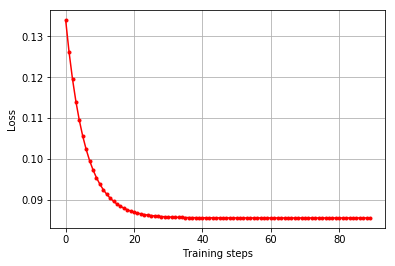

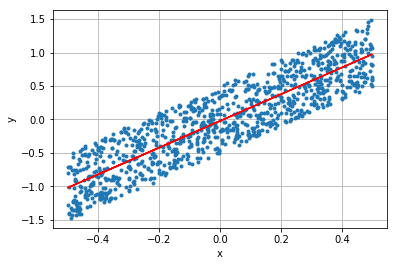

In [9]:
slope_hist = np.array(history)[:, 0]
offset_hist = np.array(history)[:, 1]
loss_hist = np.array(history)[:, 2]

plt.plot(loss_hist[10:], 'r.-')
plt.xlabel('Training steps')
plt.ylabel('Loss')
plt.grid()
plt.show()

plt.plot(x_train, y_train, '.')
plt.plot(x_train, slope_hist[-1] * x_train + offset_hist[-1], 'r-')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

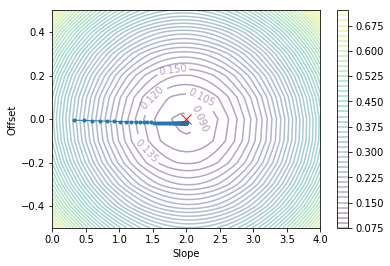

In [10]:
def loss_function_field(m, n, xref, yref):
    return np.mean(np.square(yref - m * xref - n ))

_m = np.arange(-0, 4.01, 0.1)
_n = np.arange(-0.5, 0.51, 0.1)
M, N = np.meshgrid(_m, _n)

Z = np.zeros(M.shape)
for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        Z[i, j] = loss_function_field(M[i, j], N[i, j],
                                      x_train, y_train)
        
# matplotlib.rcParams['figure.figsize'] = (10.0, 6.5)

cp = plt.contour(M, N, Z, 50, vmin=Z.min(), vmax=Z.max(), alpha=0.4)
plt.clabel(cp, cp.levels[:6])
plt.colorbar()
m = slope_hist[-1]
n = offset_hist[-1]
plt.plot(slope_hist, offset_hist, '.-', lw=1)
plt.plot([ref_slope], [ref_offset], 'rx', ms=10)
plt.xlim([_m.min(), _m.max()])
plt.ylim([_n.min(), _n.max()])
plt.xlabel('Slope')
plt.ylabel('Offset')
plt.show()

# matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)